# Runs the qsub script (that runs the script version of 15_edit_peak_overlaps_v4) across several samples at once. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import os
from qtools import Submitter
from tqdm import tnrange, tqdm_notebook
from collections import defaultdict

import calculate_editc_near_peaks as ce

# Make sure to comment out the ```cmd += '--bg_edits_file {} '.format(bg_edits_file)``` in cell 6 if we aren't using the bg edits as a filter!

In [2]:
input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info'
output_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/figure_1/outputs/editc_bar_graphs/no_filter/'

In [3]:
rbp = 'RBFOX2_orig'
d = 50
rand_bed = '/projects/ps-yeolab3/bay001/annotations/hg19/gencode_v19/hg19_v19_basic_cds_and_three_prime_utrs.bed'
chrom_sizes = '/projects/ps-yeolab3/bay001/annotations/hg19/hg19.chrom.sizes'
bg_edits_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/ApoControl-1000_S21_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.bed'
num_rand_trials = 100
conf = 0 # use all edits to calculate edit/C
l10p = 3 # log10p to subset eCLIP peaks if applicable
l2fc = 3 # log2 fold to subset eCLIP peaks if applicable

In [4]:
all_annotated = sorted(glob.glob(os.path.join(input_dir, 'RBFOX2-1000*.annotated')))
print(len(all_annotated))
all_annotated

2


['/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.annotated',
 '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01_noRmDup.annotated']

In [5]:
params = {
    "TIA1": {
        "EDIT_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "PEAK_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/TIA1_reproducible_peaks.bed.with.TTTTT.bed",
        "PEAK_ANNOTATED_TYPE": "motif",
        "BAM_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/20200228_kris_rnaseq/results",
        "BW_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "MOTIF_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/motif_coords/TTTTT_TIA_MOTIF_POSITIONS_ALL.bed"
    },
    "RBFOX2_orig": {
        "EDIT_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "PEAK_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.with.GCATG.bed",
        "PEAK_ANNOTATED_TYPE": "motif",
        "BAM_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/20191003_riboseq/results/",
        "BW_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "MOTIF_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/motif_coords/GCATG_RBFOX_MOTIF_POSITIONS_ALL.bed"
    },
    "RBFOX2_timepoints": {
        "EDIT_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "PEAK_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.with.GCATG.bed",
        "PEAK_ANNOTATED_TYPE": "motif",
        "BAM_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq",
        "BW_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "MOTIF_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/motif_coords/GCATG_RBFOX_MOTIF_POSITIONS_ALL.bed"
    },
    "RBFOX2_T": {
        "EDIT_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "PEAK_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.with.GCATG.bed",
        "PEAK_ANNOTATED_TYPE": "motif",
        "BAM_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/20200228_kris_rnaseq/results",
        "BW_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "MOTIF_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/motif_coords/GCATG_RBFOX_MOTIF_POSITIONS_ALL.bed"
    },
    "RBFOX2_Samples": {
        "EDIT_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "PEAK_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.with.GCATG.bed",
        "PEAK_ANNOTATED_TYPE": "motif",
        "BAM_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/20200309_kris_rnaseq_all",
        "BW_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "MOTIF_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/motif_coords/GCATG_RBFOX_MOTIF_POSITIONS_ALL.bed"
    },
    "SRSF1": {
        "EDIT_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "PEAK_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/301.01v02.IDR.out.0102merged.bed.annotated_proxdist_miRlncRNA.blacklist_removed.with.TGGA.bed",
        "PEAK_ANNOTATED_TYPE": "motif",
        "BAM_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/20200328_kris_rnaseq/results",
        "BW_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "MOTIF_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/motif_coords/FAKE_MOTIF.bed"
    },
    "SLBP": {
        "EDIT_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "PEAK_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/histone_genes.with.TTTTC.bed",
        "PEAK_ANNOTATED_TYPE": "motif",
        "BAM_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq",
        "BW_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "MOTIF_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/motif_coords/FAKE_MOTIF.bed"
    },
    "SLBP_merged": {
        "EDIT_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "PEAK_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/histone_genes.with.TTTTC.bed",
        "PEAK_ANNOTATED_TYPE": "motif",
        "BAM_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq",
        "BW_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "MOTIF_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/motif_coords/FAKE_MOTIF.bed"
    },
    "SLBP_merged_eclip": {
        "EDIT_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "PEAK_FILE": "/home/bay001/projects/kris_apobec_20200121/reference_data/SLBP_K562_IDR.bed",
        "PEAK_ANNOTATED_TYPE": "motif",
        "BAM_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq",
        "BW_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "MOTIF_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/motif_coords/FAKE_MOTIF.bed"
    },
    "RBFOX2_Samples_TEST": {
        "EDIT_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "PEAK_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/histone_genes.with.TTTTC.bed",
        "PEAK_ANNOTATED_TYPE": "motif",
        "BAM_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/20200309_kris_rnaseq_all",
        "BW_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "MOTIF_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/motif_coords/GCATG_RBFOX_MOTIF_POSITIONS_ALL.bed"
    },
    "SLBP_merged_TEST": {
        "EDIT_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "PEAK_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.with.GCATG.bed",
        "PEAK_ANNOTATED_TYPE": "motif",
        "BAM_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq",
        "BW_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "MOTIF_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/motif_coords/GCATG_RBFOX_MOTIF_POSITIONS_ALL.bed"
    },
    "TIA1_TEST": {
        "EDIT_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "PEAK_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.with.GCATG.bed",
        "PEAK_ANNOTATED_TYPE": "motif",
        "BAM_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/20200228_kris_rnaseq/results",
        "BW_DIR": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info",
        "MOTIF_FILE": "/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/motif_coords/GCATG_RBFOX_MOTIF_POSITIONS_ALL.bed"
    },
}

# Write the score commands

In [6]:
cmds = []
for annotated in all_annotated:
    motif_file = params[rbp]['MOTIF_FILE'] # This provides my script with genome coordinates of any motif that was found
    peak_file = params[rbp]['PEAK_FILE']
    annotated_type = params[rbp]['PEAK_ANNOTATED_TYPE'] # This basically tells my script how to read the peak file. 
    
    if rbp == 'SLBP_merged' or rbp == 'SLBP_merged_TEST' or rbp == 'SLBP_merged_eclip': # i didn't name these consistently like the others so they get special naming treatment :/
        prefix = os.path.basename(annotated).replace('_merged_a0_b0_e0.01.annotated','')
        bam_file = os.path.join(params[rbp]['BAM_DIR'], prefix + '_merged.bam') # this needs to be the original RNAseq output, used to set gene expression (TPM) cutoffs for our randomized gene list
        pos_bw = os.path.join(params[rbp]['BW_DIR'], prefix + '_merged_a0_b0_e0.01.fwd.sorted.rmdup.readfiltered.sorted.bw') # used to calculate coverage across C's
        neg_bw = os.path.join(params[rbp]['BW_DIR'], prefix + '_merged_a0_b0_e0.01.rev.sorted.rmdup.readfiltered.sorted.bw') # used to calculate coverage across C's
    else:
        prefix = os.path.basename(annotated).replace('.sorted_a0_b0_e0.01.annotated','')
        bam_file = os.path.join(params[rbp]['BAM_DIR'], prefix + '.sorted.bam') # this needs to be the original RNAseq output, used to set gene expression (TPM) cutoffs for our randomized gene list
        pos_bw = os.path.join(params[rbp]['BW_DIR'], prefix + '.sorted_a0_b0_e0.01.fwd.sorted.rmdup.readfiltered.sorted.bw') # used to calculate coverage across C's
        neg_bw = os.path.join(params[rbp]['BW_DIR'], prefix + '.sorted_a0_b0_e0.01.rev.sorted.rmdup.readfiltered.sorted.bw') # used to calculate coverage across C's
    sample_output_dir = os.path.join(output_dir, prefix)
    if not os.path.exists(sample_output_dir):
        ! mkdir $sample_output_dir
    cmd = 'module load python3essential;python /home/bay001/projects/kris_apobec_20200121/scripts/calculate_editc_near_peaks.py '
    cmd += '--rand_bed {} '.format(rand_bed)
    cmd += '--motif_file {} '.format(motif_file)
    cmd += '--edits_file {} '.format(annotated)
    cmd += '--bg_edits_file {} '.format(bg_edits_file)
    cmd += '--peak {} '.format(peak_file)
    cmd += '--annotated_type {} '.format(annotated_type)
    cmd += '--pos_bw {} '.format(pos_bw)
    cmd += '--neg_bw {} '.format(neg_bw)
    cmd += '--d {} '.format(d)
    cmd += '--bam_file {} '.format(bam_file)
    cmd += '--chrom_sizes {} '.format(chrom_sizes)
    cmd += '--num_rand_trials {} '.format(num_rand_trials)
    cmd += '--output_dir {} '.format(sample_output_dir)
    cmd += '--conf {} '.format(conf)
    cmd += '--l10p {} '.format(l10p)
    cmd += '--l2fc {} '.format(l2fc)
    cmds.append(cmd)
print(len(cmds))

2


In [7]:
Submitter(commands=cmds, job_name='editc_bar-{}'.format(rbp), array=True, nodes=1, ppn=8, submit=False, walltime='8:00:00', queue='home-yeo')

Writing 2 tasks as an array-job.
Wrote commands to editc_bar-RBFOX2_orig.sh.


# Copying the plotting code from calculate_editc_near_peaks.py to more finely manipulate/modify the plot

In [10]:
# Just temporary directories and labels to feed into certain functions. Since these files are already created by the calculate_editc_near_peaks, we don't need to re-make them here.
tmp_output_dir = '/home/bay001/projects/kris_apobec_20200121/temporary_data/figures'
tmp_full_prefix = '_merged'

"""
real_bins_file = os.path.join(
    output_dir, 
    'RBFOX2-50_S13_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out',
    'RBFOX2-50_S13_L002_R1_001.fastqTr.sorted.EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.with.GCATG.d50.c0.0.l2fc3.l10p3.real_editc_fractions_per_bin.tsv'
)
rand_bins_file = os.path.join(
    output_dir, 
    'RBFOX2-50_S13_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out',
    'RBFOX2-50_S13_L002_R1_001.fastqTr.sorted.EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.with.GCATG.d50.c0.0.l2fc3.l10p3.random_editc_fractions_per_bin.tsv'
)
new_output_svg = os.path.join(
    output_dir, 
    'RBFOX2-50_S13_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out',
    'RBFOX2-50_S13_L002_R1_001.fastqTr.sorted.EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.with.GCATG.d50.c0.0.l2fc3.l10p3.cut.svg'
)
"""

"""
real_bins_file = os.path.join(
    output_dir, 
    'SLBP_1000_48hr',
    'SLBP_1000_48hr_merged_a0_b0_e0.01.histone_genes.with.TTTTC.d50.c0.0.l2fc3.l10p3.real_editc_fractions_per_bin.tsv'
)
rand_bins_file = os.path.join(
    output_dir, 
    'SLBP_1000_48hr',
    'SLBP_1000_48hr_merged_a0_b0_e0.01.histone_genes.with.TTTTC.d50.c0.0.l2fc3.l10p3.random_editc_fractions_per_bin.tsv'
)
new_output_svg = os.path.join(
    output_dir, 
    'SLBP_1000_48hr',
    'SLBP_1000_48hr_merged_a0_b0_e0.01.histone_genes.with.TTTTC.d50.c0.0.l2fc3.l10p3.cut.svg'
)
"""

real_bins_file = os.path.join(
    output_dir, 
    'SLBP_1000_72hr',
    'SLBP_1000_72hr_merged_a0_b0_e0.01.SLBP_K562_IDR.d50.c0.0.l2fc3.l10p3.real_editc_fractions_per_bin.tsv'
)
rand_bins_file = os.path.join(
    output_dir, 
    'SLBP_1000_72hr',
    'SLBP_1000_72hr_merged_a0_b0_e0.01.SLBP_K562_IDR.d50.c0.0.l2fc3.l10p3.random_editc_fractions_per_bin.tsv'
)
new_output_svg = os.path.join(
    output_dir, 
    'SLBP_1000_72hr',
    'SLBP_1000_72hr_merged_a0_b0_e0.01.SLBP_K562_IDR.d50.c0.0.l2fc3.l10p3.cut.svg'
)

"""
real_bins_file = os.path.join(
    output_dir, 
    'RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out',
    'RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.with.GCATG.d50.c0.0.l2fc3.l10p3.real_editc_fractions_per_bin.tsv'
)
rand_bins_file = os.path.join(
    output_dir, 
    'RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out',
    'RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.with.GCATG.d50.c0.0.l2fc3.l10p3.random_editc_fractions_per_bin.tsv'
)
new_output_svg = os.path.join(
    output_dir, 
    'RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out',
    'RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.with.GCATG.d50.c0.0.l2fc3.l10p3.cut.svg'
)
"""

"""
real_bins_file = os.path.join(
    output_dir, 
    'without_ApoControl-1000_filter/Sample28_S21_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out',
    'Sample28_S21_merged.fastqTr.sorted.EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.with.GCATG.d25.c0.0.l2fc3.l10p3.real_editc_fractions_per_bin.tsv'
)
rand_bins_file = os.path.join(
    output_dir, 
    'without_ApoControl-1000_filter/Sample28_S21_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out',
    'Sample28_S21_merged.fastqTr.sorted.EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.with.GCATG.d25.c0.0.l2fc3.l10p3.random_editc_fractions_per_bin.tsv'
)
"""

"""
real_bins_file = os.path.join(
    output_dir, 
    'without_ApoControl-1000_filter/Sample27_S37_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out',
    'Sample27_S37_merged.fastqTr.sorted.EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.with.GCATG.d25.c0.0.l2fc3.l10p3.real_editc_fractions_per_bin.tsv'
)
rand_bins_file = os.path.join(
    output_dir, 
    'without_ApoControl-1000_filter/Sample27_S37_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out',
    'Sample27_S37_merged.fastqTr.sorted.EV42_01.basedon_EV42_01.peaks.l2inputnormnew.bed.compressed.bed.with.GCATG.d25.c0.0.l2fc3.l10p3.random_editc_fractions_per_bin.tsv'
)
"""

"""
real_bins_file = os.path.join(
    output_dir, 
    'Tia1_1000ng_1_S14_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out',
    'Tia1_1000ng_1_S14_L001_R1_001.fastqTr.sorted.TIA1_reproducible_peaks.bed.with.TTTTT.d50.c0.0.l2fc3.l10p3.real_editc_fractions_per_bin.tsv'
)
rand_bins_file = os.path.join(
    output_dir, 
    'Tia1_1000ng_1_S14_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out',
    'Tia1_1000ng_1_S14_L001_R1_001.fastqTr.sorted.TIA1_reproducible_peaks.bed.with.TTTTT.d50.c0.0.l2fc3.l10p3.random_editc_fractions_per_bin.tsv'
)
new_output_svg = os.path.join(
    output_dir, 
    'Tia1_1000ng_1_S14_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out',
    'Tia1_1000ng_1_S14_L001_R1_001.fastqTr.sorted.TIA1_reproducible_peaks.bed.with.TTTTT.d50.c0.0.l2fc3.l10p3.cut.svg'
)
"""
real_bins = pd.read_csv(real_bins_file, sep='\t', index_col=0)
rand_bins = pd.read_csv(rand_bins_file, sep='\t', index_col=0)
real_bins

,fraction,class,trial
0.0000,1.000000,real,0
0.0022,0.162162,real,0
0.0044,0.081081,real,0
0.0066,0.040541,real,0
0.0088,0.027027,real,0
0.0109,0.027027,real,0
0.0131,0.027027,real,0
0.0153,0.013514,real,0
0.0175,0.013514,real,0
0.0197,0.013514,real,0


In [11]:
rand_bins.columns = rand_bins.columns.map(int)
rand_bins

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0.0000,1.000000,1.000000,1.000000,1.000000,1.000,1.000,1.000000,1.000,1.000000,1.00000,1.000000,1.0,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.0022,0.007634,0.031496,0.054422,0.031250,0.016,0.040,0.022388,0.032,0.038760,0.04065,0.031746,0.0,0.055556,0.01626,0.024590,0.063830,0.039370,0.014925,0.030075,0.043478,0.023810,0.015152,0.015152,0.052632,0.03252,0.037313,0.016529,0.031008,0.039683,0.016,0.036232,0.032,0.030769,0.03252,0.031250,0.008696,0.024194,0.014493,0.037037,0.023438,0.014599,0.039062,0.074627,0.030303,0.039062,0.056911,0.035211,0.070312,0.04878,0.022556,0.054264,0.015504,0.016,0.031496,0.007194,0.033333,0.048387,0.056,0.061538,0.028986,0.052632,0.017094,0.04065,0.047619,0.025424,0.043796,0.015504,0.052239,0.024,0.050000,0.073529,0.039370,0.035461,0.023256,0.056911,0.04878,0.038760,0.030303,0.014815,0.022388,0.043796,0.008197,0.056452,0.046512,0.035714,0.061947,0.033058,0.02439,0.015504,0.030769,0.069767,0.007874,0.033333,0.031250,0.037879,0.031008,0.046512,0.016129,0.066176,0.029412
0.0044,0.000000,0.007874,0.027211,0.007812,0.000,0.008,0.007463,0.000,0.015504,0.00813,0.015873,0.0,0.007937,0.00000,0.008197,0.035461,0.015748,0.000000,0.000000,0.026087,0.015873,0.007576,0.000000,0.022556,0.00813,0.014925,0.000000,0.000000,0.015873,0.008,0.014493,0.016,0.007692,0.00813,0.023438,0.000000,0.016129,0.000000,0.007407,0.007812,0.007299,0.007812,0.037313,0.007576,0.000000,0.008130,0.014085,0.023438,0.02439,0.007519,0.023256,0.015504,0.008,0.007874,0.000000,0.008333,0.016129,0.008,0.023077,0.000000,0.022556,0.008547,0.03252,0.020408,0.016949,0.021898,0.007752,0.022388,0.016,0.016667,0.044118,0.015748,0.014184,0.007752,0.016260,0.01626,0.007752,0.007576,0.000000,0.000000,0.014599,0.000000,0.024194,0.023256,0.007143,0.026549,0.016529,0.00000,0.015504,0.007692,0.015504,0.000000,0.008333,0.015625,0.000000,0.015504,0.031008,0.000000,0.029412,0.000000
0.0066,0.000000,0.000000,0.013605,0.007812,0.000,0.000,0.007463,0.000,0.015504,0.00000,0.007937,0.0,0.000000,0.00000,0.008197,0.007092,0.007874,0.000000,0.000000,0.026087,0.007937,0.000000,0.000000,0.000000,0.00813,0.007463,0.000000,0.000000,0.000000,0.008,0.007246,0.016,0.000000,0.00813,0.015625,0.000000,0.008065,0.000000,0.007407,0.007812,0.000000,0.007812,0.014925,0.000000,0.000000,0.000000,0.000000,0.015625,0.01626,0.007519,0.007752,0.000000,0.008,0.000000,0.000000,0.000000,0.008065,0.000,0.007692,0.000000,0.015038,0.008547,0.01626,0.006803,0.008475,0.021898,0.000000,0.022388,0.000,0.000000,0.036765,0.015748,0.007092,0.007752,0.008130,0.00813,0.000000,0.000000,0.000000,0.000000,0.014599,0.000000,0.024194,0.023256,0.000000,0.017699,0.016529,0.00000,0.007752,0.007692,0.007752,0.000000,0.008333,0.007812,0.000000,0.007752,0.015504,0.000000,0.022059,0.000000
0.0088,0.000000,0.000000,0.006803,0.007812,0.000,0.000,0.000000,0.000,0.007752,0.00000,0.007937,0.0,0.000000,0.00000,0.008197,0.007092,0.007874,0.000000,0.000000,0.026087,0.000000,0.000000,0.000000,0.000000,0.00813,0.000000,0.000

# Code from calculate_editc_near_peaks.py

In [12]:
rand_bins_melted = rand_bins.reset_index().melt(
    id_vars='index', value_name='fraction', var_name='trial'
).set_index('index')
rand_bins_melted['class'] = 'rand'
rand_bins_melted.head()

,trial,fraction,class
index,,,
0.0000,0,1.000000,rand
0.0022,0,0.007634,rand
0.0044,0,0.000000,rand
0.0066,0,0.000000,rand
0.0088,0,0.000000,rand


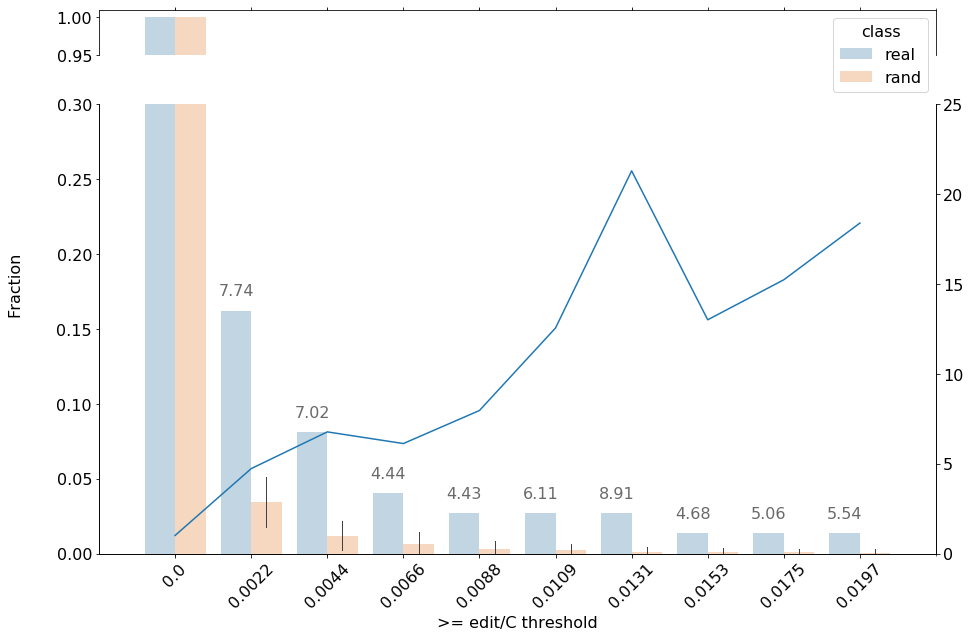

In [14]:
import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

bins = pd.concat([real_bins, rand_bins_melted])
bins.fillna(0, inplace=True)

###
# Seaborn will plot standard deviation for us, but we need 
# to manually get the numbers for z-score calculation
###
rand_bins['mean_rand_fraction'] = rand_bins.mean(axis=1)
rand_bins['standard_deviation'] = rand_bins[list(range(0, num_rand_trials))].std(axis=1)

zscore_table = ce.calculate_zscore(
    real_bins=real_bins, 
    rand_bins=rand_bins, 
    output_dir=tmp_output_dir, 
    full_prefix=tmp_full_prefix
)

### 
# Compute blue vs orange bar @see get_ratio_real_rand()
###
ratio = defaultdict()
for i in zscore_table.index:
    ratio[i] = ce.get_ratio_real_rand(i, zscore_table)

ratio = pd.DataFrame(ratio, index=['ratio']).T.reset_index()
bins.reset_index(inplace=True)

###
# Plot the main figure. 
###
# fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15, 10), sharex=False, gridspec_kw={'height_ratios':[1, 1, 0.3]})
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios':[0.1, 1]})

for ax in (ax1, ax2):
    sns.barplot(x='index', y='fraction', hue='class', data=bins, alpha=0.3, ci='sd', errwidth=1, ax=ax)
    ax.set_xlim(-1, 10)
    ax.set_xlabel(">= edit/C threshold")
    # ax.set_ylabel("fraction of peaks containing edit/c scores above threshold")



### Toggle whether we want to explicitly have a NA for z-score at first bin ###
"""ax1.text(
    ax1.patches[0].get_x()-.03, 
    ax1.patches[0].get_height()+0.01, 
    "N/A", 
    fontsize=8,
    color='dimgrey'
)"""

### Set individual split limits
ax1.set_ylim(0.95, 1.01)
ax1.set_ylabel("")
sns.despine(ax=ax1, top=False, bottom=True, left=False, right=False)

ax2.set_ylim(0, 0.3)
ax2.set_ylabel("")
ax2.get_legend().remove()
ax2.tick_params(axis='x', rotation=45)
sns.despine(ax=ax2, top=True, bottom=False, left=False, right=False)


for i in range(1, 10):
    # get_x pulls left or right; get_height pushes up or down
    ax2.text(
        ax2.patches[i].get_x()-.03, 
        ax2.patches[i].get_height()+0.01, 
        "{:.2f}".format(zscore_table.iloc[i]['zscore']), 
        fontsize=16,
        color='dimgrey'
    )
    
### Toggle whether or not we want to split the fold change line
# axt1 = ax1.twinx()
# ratio['ratio'].plot(ax=axt1)    
# axt1.set_ylim(9, 20)

axt2 = ax2.twinx()
ratio['ratio'].plot(ax=axt2)    
axt2.set_ylim(0, 25)
axt2.set_xlim(-1, 10)
sns.despine(ax=axt2, top=True, bottom=False, left=False, right=False)

fig.text(0.04, 0.5, 'Fraction', va='center', rotation='vertical')

fig.savefig(
    new_output_svg
)

In [12]:
"""ratio.loc[-1, 'ratio'] = 0
ratio.sort_index(inplace=True)
sns.heatmap(ratio[['ratio']].T, ax=ax3, cmap='Blues', cbar=False, xticklabels=False, yticklabels=False)
ax3.set_xlim(0, 10)"""

"ratio.loc[-1, 'ratio'] = 0\nratio.sort_index(inplace=True)\nsns.heatmap(ratio[['ratio']].T, ax=ax3, cmap='Blues', cbar=False, xticklabels=False, yticklabels=False)\nax3.set_xlim(0, 10)"